# Python library : torch_mi

The torch_mi library provides implementations of three different methods for calculating Mutual Information:

- KNN (K-Nearest Neighbors)
- KDE (Kernel Density Estimation)
- Vectorized bins count method that can be differentiable.

These methods can be used to measure the amount of information shared between two variables in a dataset


# References :

- [KNN] "Estimating Mutual Information", Alexander Kraskov, Harald Stoegbauer, Peter Grassberger - https://arxiv.org/abs/cond-mat/0305641

- [Bins] https://en.wikipedia.org/wiki/Mutual_information

- [KDE] "Estimation of Mutual Information Using Kernel Density Estimators", Moon, Young-Il & Rajagopalan, Balaji & Lall, Upmanu - https://www.researchgate.net/publication/13324976_Estimation_of_Mutual_Information_Using_Kernel_Density_Estimators


# Install library


In [ ]:
%%bash
pip install https://github.com/Simon-Bertrand/MutualInformation-PyTorch/archive/main.zip

# Import library


In [118]:
import torch_mi

# Generate some data and define some utils functions


In [119]:
%%bash
pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [120]:
import torch, math
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt


def createCovMat(stdX, stdY, p):
    return torch.tensor([[stdX**2, p * stdX * stdY], [p * stdX * stdY, stdY**2]])


def miGroundTruth(covMat):
    r = covMat[0, 1] / covMat.diag().prod().sqrt()
    return -1 / 2 * math.log(1 - r**2)


def entropyGroundTruth(covMat):
    r = covMat[0, 1] / torch.diag(covMat).prod().sqrt()
    return (
        1 / 2 + 1 / 2 * math.log(2 * math.pi) + math.log(covMat[0, 0].sqrt()),
        1 / 2 + 1 / 2 * math.log(2 * math.pi) + math.log(covMat[1, 1].sqrt()),
        1
        + math.log(2 * math.pi)
        + math.log(torch.diag(covMat).prod().sqrt())
        + 1 / 2 * math.log(1 - r**2),
    )


def getMultivariateNormal(covMat, meanX, meanY):
    return MultivariateNormal(torch.Tensor([meanX, meanY]), covMat)

In [121]:
# Define parameters
nNeighbours = 3
nBins = 20

# Define data parameters and generate it
r = 0.50
means = [1, 1]
covMat = createCovMat(1, 1, r)
B, C, H, W = 1, 1, 32, 32
x, y = getMultivariateNormal(covMat, *means).sample((B, C, H, W)).moveaxis(-1, 0)

# Print ground truth mutual information for the normal multivariate case
print("Ground truth MI:", miGroundTruth(covMat))

# Instanciate four methods
binsMiSoft = torch_mi.BinsCountMutualInformation(nBins=nBins, mode="soft")  # Default mode
binsMiDiscrete = torch_mi.BinsCountMutualInformation(nBins=nBins, mode="discrete")
kdeMi = torch_mi.KdeMutualInformation(nBins=nBins)
knnMi = torch_mi.KnnMutualInformation(nNeighbours=nNeighbours)

BC, HW = x.size(0) * x.size(1), x.size(2) * x.size(3)

Ground truth MI: 0.14384103622589045


# Plot density based joint distribution


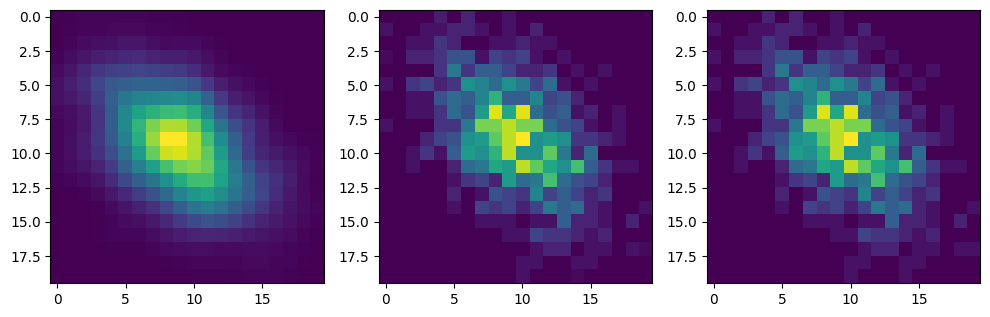

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
axes[0].imshow(kdeMi.computePxy(x.view(BC, HW), y.view(BC, HW))[0])
axes[1].imshow(binsMiSoft.computePxy(x.view(BC, HW), y.view(BC, HW))[0])
axes[2].imshow(binsMiDiscrete.computePxy(x.view(BC, HW), y.view(BC, HW))[0])

# Compute Mutual Information for each method


In [127]:
dict(
    binsMiSoft=float(binsMiSoft(x, y)),
    binsMiDiscrete=float(binsMiDiscrete(x, y)),
    kdeMi=float(kdeMi(x, y)),
    knnMi=float(knnMi(x, y)),
    gt=float(miGroundTruth(covMat)),
)

{'binsMiSoft': 0.2378513067960739,
 'binsMiDiscrete': 0.24249428510665894,
 'kdeMi': 0.10346297174692154,
 'knnMi': 0.14206981658935547,
 'gt': 0.14384103622589045}

# Compute some stats


In [128]:
%%bash
pip install tqdm pandas


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [137]:
import time
import pandas as pd
from tqdm import tqdm

nRealizations = 64


def task(args):
    r, n = args
    covMat = createCovMat(1, 1, r)
    means = [0, 0]
    x, y = getMultivariateNormal(covMat, *means).sample((nRealizations, 1, n, n)).moveaxis(-1, 0)
    start = time.time()
    knn = knnMi(x, y).mean()
    knnTime = 1000 * (time.time() - start) / nRealizations

    start = time.time()
    kde = kdeMi(x, y).mean()
    kdeTime = 1000 * (time.time() - start) / nRealizations

    start = time.time()
    bins = binsMiSoft(x, y).mean()
    binsTime = 1000 * (time.time() - start) / nRealizations

    return {
        "n": float(n**2),
        "r": float(r),
        "gt": float(miGroundTruth(covMat)),
        **dict(zip(["varX", "varY"], covMat.diag().tolist())),
        **dict(zip(["meanX", "meanY"], means)),
        "knn:score": float(knn),
        "kde:score": float(kde),
        "bins:score": float(bins),
        "knn:duration": float(knnTime),
        "kde:duration": float(kdeTime),
        "bins:duration": float(binsTime),
    }


rs = (1 - (-2 * torch.linspace(0, -0.5 * math.log(1 - 0.99**2), 25)).exp()).sqrt()
N = torch.logspace(1, 1.85, 7).to(torch.int)

stats = pd.DataFrame(
    list(
        tqdm(
            map(task, ((r, n) for r in rs for n in N)),
            total=len(rs) * len(N),
        )
    )
).assign(
    **{
        "knn:score_err": lambda x: (x["knn:score"].mean() - x["gt"]) / (x["gt"].abs()),
        "kde:score_err": lambda x: (x["kde:score"].mean() - x["gt"]) / (x["gt"].abs()),
        "bins:score_err": lambda x: (x["bins:score"].mean() - x["gt"]) / (x["gt"].abs()),
    }
)
stats

100%|██████████| 175/175 [02:21<00:00,  1.24it/s]


,n,r,gt,varX,varY,meanX,meanY,knn:score,kde:score,bins:score,knn:duration,kde:duration,bins:duration,knn:score_err,kde:score_err,bins:score_err
0,100.0,0.00,-0.000000,1.0,1.0,0,0,0.025364,0.031412,0.613674,0.149239,0.017937,0.028118,inf,inf,inf
1,169.0,0.00,-0.000000,1.0,1.0,0,0,0.022774,0.025705,0.398326,0.059105,0.024863,0.032410,inf,inf,inf
2,361.0,0.00,-0.000000,1.0,1.0,0,0,0.016111,0.018990,0.235503,0.427667,0.056162,0.054341,inf,inf,inf
3,676.0,0.00,-0.000000,1.0,1.0,0,0,0.006813,0.013945,0.111838,1.559779,0.174541,0.146985,inf,inf,inf
4,1296.0,0.00,-0.000000,1.0,1.0,0,0,0.009105,0.009991,0.063746,5.104303,0.363801,0.248015,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,361.0,0.99,1.958519,1.0,1.0,0,0,1.965341,0.696133,1.570958,0.408452,0.053864,0.044614,-0.497549,-0.736909,-0.516856
171,676.0,0.99,1.958519,1.0,1.0,0,0,1.982172,0.778486,1.555785,1.459435,0.143573,0.126090,-0.497549,-0.736909,-0.516856
172,1296.0,0.99,1.958519,1.0,1.0,0,0,1.981399,0.863145,1.534130,4.882187,0.346087,0.272118,-0.497549,-0.736909,-0.516856
173,2601.0,0.99,1.958519,1.0,1.0,0,0,1.972334,0.953513,1.493871,18.187419,0.808019,0.453766,-0.497549,-0.736909,-0.516856


# Plot method precision


In [ ]:
!pip install seaborn

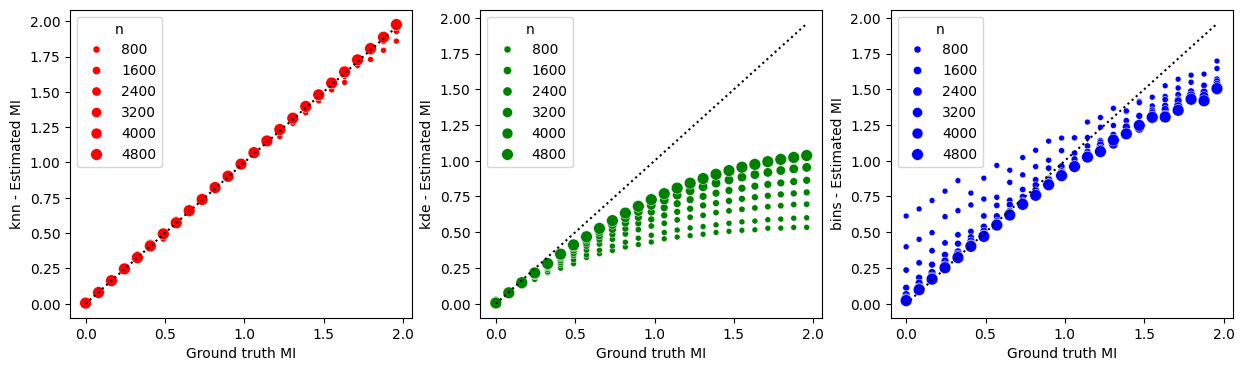

In [138]:
import seaborn as sns

fig, axis = plt.subplots(1, 3, figsize=(15, 4))
plotsMetadata = [
    dict(y="knn:score", color="r"),
    dict(y="kde:score", color="g"),
    dict(y="bins:score", color="b"),
]
for i, ax in enumerate(axis):
    sns.scatterplot(
        data=stats,
        size="n",
        x="gt",
        y=plotsMetadata[i]["y"],
        ax=ax,
        color=plotsMetadata[i]["color"],
    )
    ax.plot(
        *2 * [torch.linspace(stats["gt"].min(), stats["gt"].max(), 40)],
        linestyle="dotted",
        color="black",
    )
    ax.set_xlabel("Ground truth MI")
    ax.set_ylabel(plotsMetadata[i]["y"].split(":")[0] + " - Estimated MI")

# Plot method dependency with the correlation coefficient


<Axes: xlabel='r'>

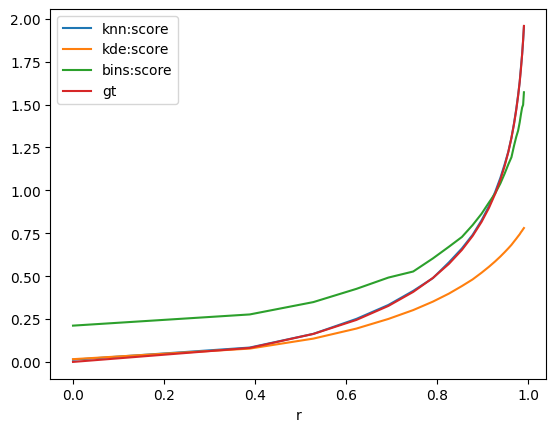

In [139]:
stats.groupby("r").agg(
    {
        "knn:score": "mean",
        "kde:score": "mean",
        "bins:score": "mean",
        "gt": "mean",
    }
).plot()

# Show method durations


<Axes: xlabel='n'>

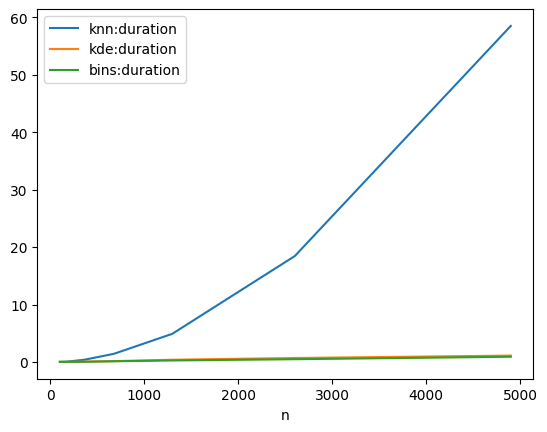

In [140]:
stats.groupby("n").agg(
    {
        "knn:duration": "mean",
        "kde:duration": "mean",
        "bins:duration": "mean",
    }
).plot()